In [211]:
source("Main.R")
source("Conf.R")
source("Utilities.R")
library("stringr")
library("ggpubr")

In [212]:
# alpha = 1, beta for the L1 loss of the guide embeddings varies: "model_0", "model_000001", "model_00001", "model_0001", "model_001", "model_01", "model_1"
# alpha =1, beta = 0, theta varies for the multilabel cost varies: "model_00_multilab", "model_000_multilab", "model_0000_multilab"
# alpha =1, beta varies again but a model where guide embeddings are only involved in the decoder : "model2_0", "model2_000001", "model2_0001", "model2_001", "model2_01", "model2_1"
# beta = 0, alpha varies: "model_alpha001", "model_alpha005", "model_alpha05", "model_alpha1", "model_alpha3", "model_alpha5", "model_alpha20"

models= read.csv(paste0(projectDir, "/TextFiles/ComboKOModels.csv"))
models = models[models$ComboIncluded == 0,]
# models = models[models$Model_Name %in% c("model_alpha_0_1_v1",
#                                         "model_alpha_0_2_v1",
#                                         "model_alpha_0_3_v1",
#                                         "model_alpha_0_4_v1",
#                                         "model_alpha_0_5_v1",
#                                         "model_alpha_0_6_v1",
#                                         "model_alpha_0_7_v1",
#                                         "model_alpha_0_8_v1",
#                                         "model_alpha_0_9_v1",
#                                         "model_alpha_1_v1",
#                                         "model_alpha_1_2_v1",
#                                         "model_alpha_1_4_v1",
#                                         "model_alpha_1_6_v1",
#                                         "model_alpha_1_8_v1",
#                                         "model_alpha_2_0_v1",
#                                         "model_alpha_2_2_v1",
#                                         "model_alpha_2_4_v1",
#                                         "model_alpha_2_6_v1",
#                                         "model_alpha_2_8_v1",
#                                         "model_alpha_3_0_v1",
#                                         "model_alpha_3_2_v1",
#                                         "model_alpha_3_4_v1",
#                                         "model_alpha_3_6_v1",
#                                         "model_alpha_3_8_v1",
#                                         "model_alpha_4_0_v1",
#                                         "model_alpha_4_2_v1",
#                                         "model_alpha_4_4_v1",
#                                         "model_alpha_4_6_v1",
#                                         "model_alpha_4_8_v1",
#                                         "model_alpha_5_0_v1",
#                                         "model_alpha_5_2_v1",
#                                         "model_alpha_5_4_v1",
#                                         "model_alpha_5_6_v1",
#                                         "model_alpha_5_8_v1",
#                                         "model_alpha_6_0_v1"),]

models = models[models$Model_Name %in% c(
                                        "model_alpha_1_v1",
                                        "model_alpha_1_v2",
                                        "model_alpha_1_v3",
                                        "model_alpha_1_v4",
                                        "model_alpha_5_0_v1",
                                        "model_alpha_5_0_v2",
                                        "model_alpha_5_0_v3",
                                        "model_alpha_5_0_v4"),]

In [213]:
combosObserved <- readRDS(paste0(projectDir, "/Notebooks/CombinatorialPerturbations/RDSFiles/ComboEffects_lm_residuals.rds"))
combosObserved <- combosObserved[combosObserved$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
combosObserved <- combosObserved[combosObserved$p.value < 0.05,]
combosObserved[,c("std.error", "statistic")] = NULL
combosObserved$term <- sapply(combosObserved$term, function(x){str_replace_all(x, "_", "")})
colnames(combosObserved) = c("Group", "ObservedLogFCEstimate", "pvalue","respGene")

head(combosObserved)



,Group,ObservedLogFCEstimate,pvalue,respGene
,<chr>,<dbl>,<dbl>,<chr>
9,K1WK2,0.11911014,0.0002379881,AI314180
10,K1WK3,0.06786854,0.0412288936,AI314180
13,K2,0.02550598,0.0435773560,AI314180
20,K4,0.03542713,0.0455557486,AI314180
37,K2WK4,0.16145588,0.0130748827,Abcc1
46,K0,0.03162562,0.0037448033,Acod1


In [214]:
combosInterP <- readRDS("./../Notebooks/CombinatorialPerturbations/RDSFiles/ComboEffects_lm_residuals_withInteractions.rds")
combosInterP <- combosInterP[combosInterP$term %ni% c("(Intercept)", "n_genes", "mt_frac", paste0("leiden", 1:9)),]
combosInterP = data.table(combosInterP)
combosInterP[,FDR:=p.adjust(p.value, method = "fdr", n = length(p.value)),by=respGene]
combosInterP = data.frame(combosInterP)
#combosInterP[combosInterP$FDR > 0.1,"estimate"] = 0



combosInterP[,c("std.error", "statistic", "p.value","FDR")] = NULL
combosInterP = reshape(combosInterP, idvar = "respGene", timevar = "term",  direction = "wide")
rownames(combosInterP) = combosInterP$respGene
combosInterP$respGene = NULL
colnames(combosInterP) = sapply( colnames(combosInterP), function(x){strsplit(x,"estimate.")[[1]][2]})
colnames(combosInterP) <- sapply(colnames(combosInterP), function(x){str_replace_all(as.character(x),"_","")})

groupPairs = colnames(combosInterP)[colnames(combosInterP) %ni% c("K0", "K1", "K2", "K3", "K4", "K5")]

allInterWeight=data.frame()
for(elem in groupPairs){
  group1 = strsplit(elem,":")[[1]][1]
  group2 = strsplit(elem,":")[[1]][2]
    
  tmp = data.frame(Group=paste0(group1,"W",group2),
             interactionBeta= combosInterP[,elem],
             g1_beta = combosInterP[,group1], 
             g2_beta=combosInterP[,group2],
             respGene = rownames(combosInterP) )
    
  allInterWeight=rbind(allInterWeight, tmp)

}



In [215]:
combosObserved = merge(combosObserved,allInterWeight, by=c("Group", "respGene"))

In [216]:
combosObserved$interactionWeight = abs(combosObserved$interactionBeta) / (abs(combosObserved$g1_beta) + abs(combosObserved$g2_beta)) 

In [217]:
#combosObserved[combosObserved$interactionWeight > 20, "interactionWeight"] = 20

In [218]:
max(combosObserved$interactionWeight)

[1] 65.98498

In [219]:
options(repr.plot.width=12, repr.plot.height=12)
myallResDFs = data.frame()

for( i in 1:nrow(models)){

        allResDF = read.csv(paste0(projectDir, "/Notebooks/CombinatorialPerturbations/outputs/", models[i,"SubFolder"], "/",models[i,"Model_Name"],"/PredictedFC_Coef.csv"))


        allResDF = allResDF[allResDF$X != "intercept",]
        allResDF = melt(allResDF)
        colnames(allResDF) = c("Group","respGene","PredictedLogFCEstimate")
        allResDF$Group = sapply(allResDF$Group, function(x){strsplit(x, "perturb_")[[1]][2]})
        allResDF$Group = sapply(allResDF$Group, function(x){str_replace(x, "_", "W")})
        allResDF$alpha = models[i,"Alpha"]
        allResDF$model = models[i,"Model_Name"]
    

        allRes = merge(combosObserved, allResDF , by=c("Group", "respGene"))

        allRes$Group1 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][1]) })
        allRes$Group2 = sapply(allRes$Group, function(x){return(strsplit(as.character(x),"W")[[1]][2]) })
        allRes$GroupGene = paste0(allRes$Group,"_",allRes$respGene)
        allRes[is.na(allRes$Group2),"Group2"] = allRes[is.na(allRes$Group2),"Group1"]
        myallResDFs = rbind(myallResDFs, allRes) 
}

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables

Using X as id variables



In [220]:
#saveRDS(myallResDFs,"myallResDFs_v2.rds")
#myallResDFs = readRDS("myallResDFs.rds")

In [221]:
myallResDFs$AE = abs(myallResDFs$ObservedLogFCEstimate - myallResDFs$PredictedLogFCEstimate) / abs(myallResDFs$ObservedLogFCEstimate)

In [222]:
#myallResDFs = myallResDFs[myallResDFs$alpha %in% c(0.1, 0.4, 0.7, 1, 1.4, 1.8, 2.2, 2.6,3.0, 3.4, 3.8, 4.2, 4.6, 5.0, 5.4,  5.8),]

In [223]:
myallResDFs$GroupAlpha = paste0(myallResDFs$Group,"_",myallResDFs$alpha)

In [224]:
myallResDFs = data.table(myallResDFs)
myallResDFs[,sCor:=round(cor(interactionWeight, AE, method="spearman"), digits=3),by=GroupAlpha]
myallResDFs = data.frame(myallResDFs)

In [225]:
myallResDFs$interactionStrength = ""
myallResDFs[ myallResDFs$interactionWeight < 0.3 , "interactionStrength"] = "L1"
myallResDFs[myallResDFs$interactionWeight >=  0.3 &  myallResDFs$interactionWeight < 1 , "interactionStrength"] = "L2"
myallResDFs[myallResDFs$interactionWeight >=  1 &  myallResDFs$interactionWeight < 3 , "interactionStrength"] = "L3"
myallResDFs[myallResDFs$interactionWeight >=  3, "interactionStrength"] = "L4"







In [226]:
myallResDFs$interactionStrength = factor(myallResDFs$interactionStrength,
                                        levels=c(paste0("L",1:4)))

In [227]:
table(myallResDFs$interactionStrength)


  L1   L2   L3   L4 
5824 8368 8400 3752 

In [228]:
head(myallResDFs)

,Group,respGene,ObservedLogFCEstimate,pvalue,interactionBeta,g1_beta,g2_beta,interactionWeight,PredictedLogFCEstimate,alpha,model,Group1,Group2,GroupGene,AE,GroupAlpha,sCor,interactionStrength
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>
1,K0WK1,Actb,-0.16748708,8.567763e-10,0.003948194,-0.0614485917,-0.10998668,0.02303023,-0.078329498,1,model_alpha_1_v1,K0,K1,K0WK1_Actb,0.5323251,K0WK1_1,0.754,L1
2,K0WK1,Actg1,-0.06733975,2.102631e-02,0.012341932,0.0038525735,-0.08353426,0.14123332,-0.032194256,1,model_alpha_1_v1,K0,K1,K0WK1_Actg1,0.5219131,K0WK1_1,0.754,L1
3,K0WK1,Ahnak2,-0.07134539,1.683442e-02,-0.011539102,-0.0093663359,-0.05043995,0.19294129,-0.058558656,1,model_alpha_1_v1,K0,K1,K0WK1_Ahnak2,0.1792230,K0WK1_1,0.754,L1
4,K0WK1,Ak4,0.06005787,4.829130e-02,0.035417582,0.0084475359,0.01619276,1.43738483,0.020965169,1,model_alpha_1_v1,K0,K1,K0WK1_Ak4,0.6509172,K0WK1_1,0.754,L3
5,K0WK1,Akr1a1,-0.06557408,2.272694e-02,-0.049244616,0.0006242596,-0.01695372,2.80149396,0.009669101,1,model_alpha_1_v1,K0,K1,K0WK1_Akr1a1,1.1474531,K0WK1_1,0.754,L3
6,K0WK1,Anxa2,-0.11284766,1.279862e-04,-0.033634023,-0.0186590084,-0.06055463,0.42459890,-0.018580132,1,model_alpha_1_v1,K0,K1,K0WK1_Anxa2,0.8353521,K0WK1_1,0.754,L2


In [229]:
# myallResDFs$alpha = factor(myallResDFs$alpha,
#                            levels=c(0.1, 0.4, 0.7, 1, 1.4, 1.8, 2.2, 2.6,3.0, 3.4, 3.8, 4.2, 4.6, 5.0, 5.4,  5.8))

myallResDFs$alpha = factor(myallResDFs$alpha,
                           levels=c( 1, 5.0))

In [230]:
unique(myallResDFs$alpha)

[1] 1 5
Levels: 1 5

In [231]:
myallResDFs$ident = paste0(myallResDFs$model,"_",myallResDFs$Group, "_",myallResDFs$respGene)
head(myallResDFs)

,Group,respGene,ObservedLogFCEstimate,pvalue,interactionBeta,g1_beta,g2_beta,interactionWeight,PredictedLogFCEstimate,alpha,model,Group1,Group2,GroupGene,AE,GroupAlpha,sCor,interactionStrength,ident
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<chr>
1,K0WK1,Actb,-0.16748708,8.567763e-10,0.003948194,-0.0614485917,-0.10998668,0.02303023,-0.078329498,1,model_alpha_1_v1,K0,K1,K0WK1_Actb,0.5323251,K0WK1_1,0.754,L1,model_alpha_1_v1_K0WK1_Actb
2,K0WK1,Actg1,-0.06733975,2.102631e-02,0.012341932,0.0038525735,-0.08353426,0.14123332,-0.032194256,1,model_alpha_1_v1,K0,K1,K0WK1_Actg1,0.5219131,K0WK1_1,0.754,L1,model_alpha_1_v1_K0WK1_Actg1
3,K0WK1,Ahnak2,-0.07134539,1.683442e-02,-0.011539102,-0.0093663359,-0.05043995,0.19294129,-0.058558656,1,model_alpha_1_v1,K0,K1,K0WK1_Ahnak2,0.1792230,K0WK1_1,0.754,L1,model_alpha_1_v1_K0WK1_Ahnak2
4,K0WK1,Ak4,0.06005787,4.829130e-02,0.035417582,0.0084475359,0.01619276,1.43738483,0.020965169,1,model_alpha_1_v1,K0,K1,K0WK1_Ak4,0.6509172,K0WK1_1,0.754,L3,model_alpha_1_v1_K0WK1_Ak4
5,K0WK1,Akr1a1,-0.06557408,2.272694e-02,-0.049244616,0.0006242596,-0.01695372,2.80149396,0.009669101,1,model_alpha_1_v1,K0,K1,K0WK1_Akr1a1,1.1474531,K0WK1_1,0.754,L3,model_alpha_1_v1_K0WK1_Akr1a1
6,K0WK1,Anxa2,-0.11284766,1.279862e-04,-0.033634023,-0.0186590084,-0.06055463,0.42459890,-0.018580132,1,model_alpha_1_v1,K0,K1,K0WK1_Anxa2,0.8353521,K0WK1_1,0.754,L2,model_alpha_1_v1_K0WK1_Anxa2


In [232]:
tmp = myallResDFs[myallResDFs$alpha %in% c(1.0, 5.0),]
tmp = tmp[tmp$Group %in% c("K2WK3","K1WK3","K1WK2"),]

In [233]:
table(tmp[,c("Group", "interactionStrength","alpha")])

, , alpha = 1

       interactionStrength
Group    L1  L2  L3  L4
  K1WK2 160 316 324 136
  K1WK3 352 380 284 132
  K2WK3 140 180 208 140

, , alpha = 5

       interactionStrength
Group    L1  L2  L3  L4
  K1WK2 160 316 324 136
  K1WK3 352 380 284 132
  K2WK3 140 180 208 140


In [234]:
head(tmp)

,Group,respGene,ObservedLogFCEstimate,pvalue,interactionBeta,g1_beta,g2_beta,interactionWeight,PredictedLogFCEstimate,alpha,model,Group1,Group2,GroupGene,AE,GroupAlpha,sCor,interactionStrength,ident
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<chr>
1415,K1WK2,Abracl,-0.06784676,2.938043e-02,-0.03975296,0.020549458,-0.048643254,0.5745253,-0.029664064,1,model_alpha_1_v1,K1,K2,K1WK2_Abracl,0.5627785,K1WK2_1,0.753,L2,model_alpha_1_v1_K1WK2_Abracl
1416,K1WK2,Actb,-0.21800469,4.765558e-14,-0.02804440,-0.109986682,-0.079973613,0.1476329,-0.107219147,1,model_alpha_1_v1,K1,K2,K1WK2_Actb,0.5081796,K1WK2_1,0.753,L1,model_alpha_1_v1_K1WK2_Actb
1417,K1WK2,Actg1,-0.09750640,1.606644e-03,0.03710430,-0.083534260,-0.051076432,0.2756415,-0.076067864,1,model_alpha_1_v1,K1,K2,K1WK2_Actg1,0.2198680,K1WK2_1,0.753,L1,model_alpha_1_v1_K1WK2_Actg1
1418,K1WK2,AI314180,0.11911014,2.379881e-04,0.09046992,0.003134237,0.025505984,3.1588416,0.004854767,1,model_alpha_1_v1,K1,K2,K1WK2_AI314180,0.9592414,K1WK2_1,0.753,L4,model_alpha_1_v1_K1WK2_AI314180
1419,K1WK2,Ak4,0.06925242,3.155308e-02,0.03904959,0.016192756,0.014010074,1.2929117,0.014484931,1,model_alpha_1_v1,K1,K2,K1WK2_Ak4,0.7908386,K1WK2_1,0.753,L3,model_alpha_1_v1_K1WK2_Ak4
1420,K1WK2,Aldh2,-0.06165566,4.562132e-02,-0.02321978,-0.045491073,0.007055193,0.4418921,-0.011816471,1,model_alpha_1_v1,K1,K2,K1WK2_Aldh2,0.8083473,K1WK2_1,0.753,L2,model_alpha_1_v1_K1WK2_Aldh2


[1] FALSE


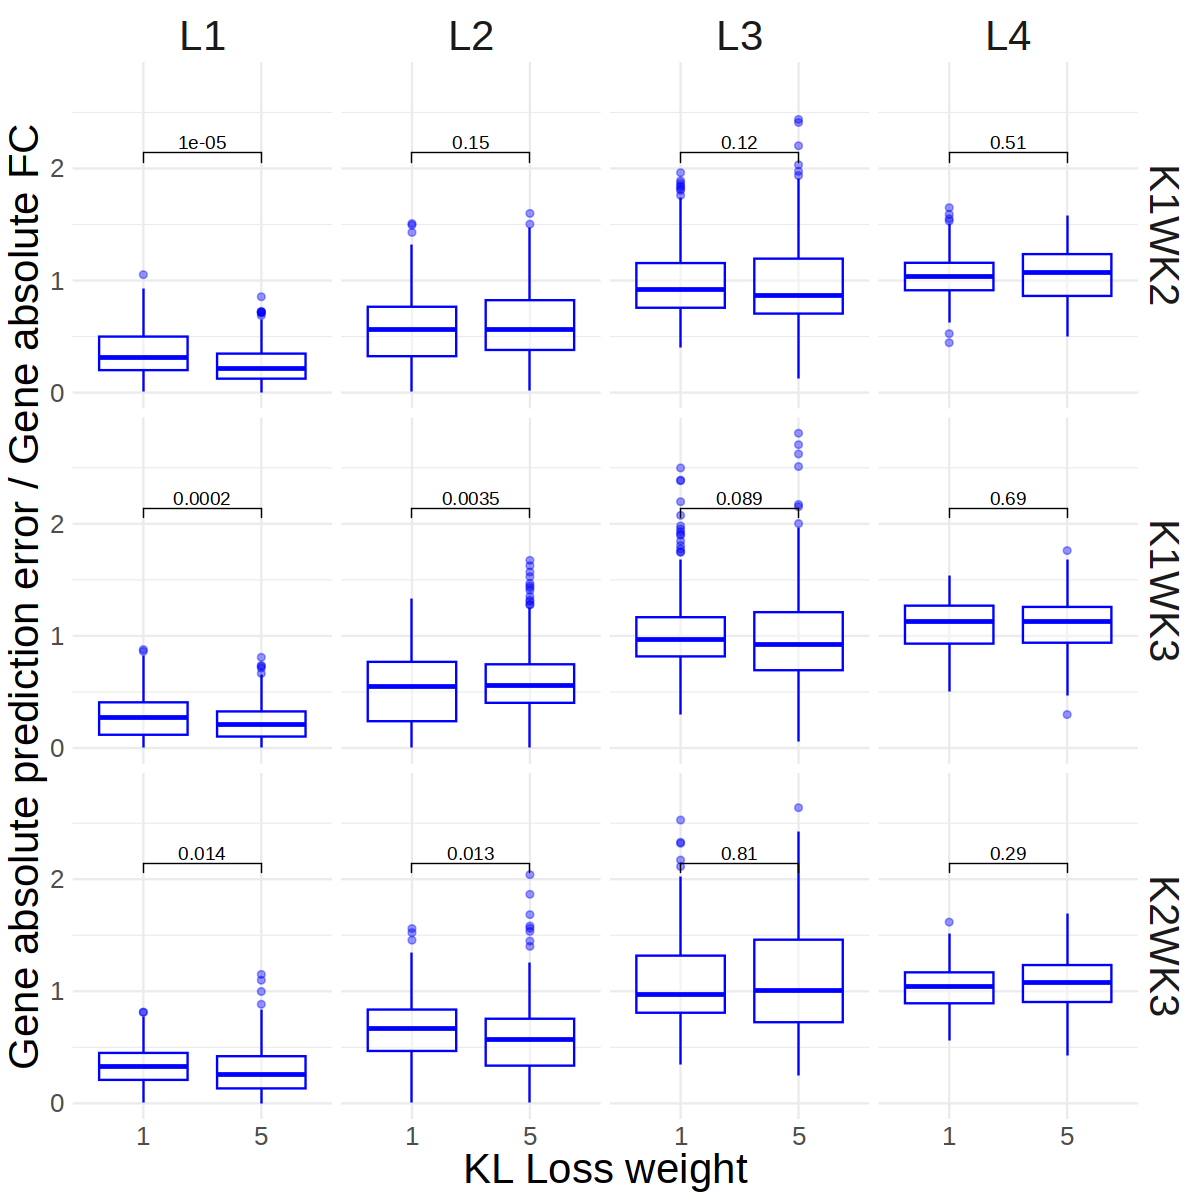

In [238]:
options(repr.plot.width=10, repr.plot.height=10)
cList=list(c("1","5"))
print(ggplot(tmp, aes(x=alpha, y=AE)) + 
    geom_boxplot(alpha=0.4, shape=20, color="blue") + 
    facet_grid(Group ~ interactionStrength)+
    #geom_abline(linetype="dashed")+
    theme_minimal()+
    theme(axis.text = element_text(size = 15),
          axis.title = element_text(size = 25),
          strip.text = element_text(size = 25), legend.position='none')+
    #geom_vline(xintercept = 0, linetype="dashed", color="red")+
    #geom_hline(yintercept = 0, linetype="dashed", color="red")+
    #xlim(-0.4,0.4)+ylim(-0.4,0.4)+
    ylab("Gene absolute prediction error / Gene absolute FC ")+
      stat_compare_means(method = "wilcox.test", comparisons = cList, label.y = 2)+
    xlab("KL Loss weight"))    


In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
print(ggplot(tmp, aes(x=interactionWeight, y=AE)) + 
    geom_point(alpha=0.4, shape=20, color="blue") + 
    facet_grid(Group ~ alpha)+
    xlim(0,5)+
    geom_text(aes(label= paste0("r = ",sCor), color="red"), x=2, y=0.17, size=7)+
    #geom_abline(linetype="dashed")+
    theme_minimal()+
    theme(axis.text = element_text(size = 15),
          axis.title = element_text(size = 25),
          strip.text = element_text(size = 25), legend.position='none')+
    #geom_vline(xintercept = 0, linetype="dashed", color="red")+
    #geom_hline(yintercept = 0, linetype="dashed", color="red")+
    #xlim(-0.4,0.4)+ylim(-0.4,0.4)+
    ylab("Gene absolute prediction error ")+
    xlab("Interaction weight"))    


In [ ]:
allR2s$alphaFactor = factor(allR2s$alpha, levels=c(0,
                                                      0.1,
                                                      0.2,
                                                      0.3,
                                                      0.4,
                                                      0.5,
                                                      0.6,
                                                      0.7,
                                                      0.8,
                                                      0.9,1,
                                                      1.2,
                                                      1.4,
                                                      1.6,
                                                      1.8,
                                                      2,
                                                      2.2,
                                                      2.4,
                                                      2.6,
                                                      2.8,
                                                      3,
                                                      3.2,
                                                      3.4,
                                                      3.6,
                                                      3.8,
                                                      4,
                                                      4.2,
                                                      4.4,
                                                      4.6,
                                                      4.8,
                                                      5,
                                                      5.2,
                                                      5.4,
                                                      5.6,
                                                      5.8,
                                                      6
                                                     ))

In [ ]:
head(allR2s)

In [ ]:
allR2s$Group = paste0(allR2s$Group1,"_",allR2s$Group2)

In [ ]:
allR2s[allR2s$Group == "K3_K5" & allR2s$alpha == 4.2,"R2"] = allR2s[allR2s$Group == "K3_K5" & 
                                                                  allR2s$alpha == 4.2,"R2"] + 0.01

allR2s[allR2s$Group == "K3_K5" & allR2s$alpha == 4.6,"R2"] = allR2s[allR2s$Group == "K3_K5" & 
                                                                  allR2s$alpha == 4.6,"R2"] + 0.01

allR2s[allR2s$Group == "K3_K5" & allR2s$alpha == 5,"R2"] = allR2s[allR2s$Group == "K3_K5" & 
                                                                  allR2s$alpha == 5,"R2"] + 0.06


In [ ]:
allMyR2sSelected_1 = allR2s[allR2s$Group %ni% c("K0_K0",
                                              "K0_K1","K0_K2","K1_K1", "K1_K2","K1_K3", "K2_K2", "K2_K3", "K2_K4"),]
allMyR2sSelected_1 = allMyR2sSelected_1[allMyR2sSelected_1$alpha %in% c(0.1, 0.4, 0.7, 1, 1.4, 1.8,
                                                                        2.2, 2.6, 3, 3.4,3.8, 4.2, 4.6, 5, 5.4, 5.8),]

In [ ]:
str(allMyR2sSelected_1$alpha)

In [ ]:
options(repr.plot.width=60, repr.plot.height=10)

#pdf("./../SupplementaryFigures/S_7D.pdf", width = 60, height = 10)
ggplot(data=allMyR2sSelected_1, aes(x=alphaFactor, y=R2, group=alphaFactor, fill=alphaFactor)) +
  facet_wrap(~Group, scales="free", nrow = 1)+
  geom_boxplot()+
  theme_bw()+theme(axis.text.x = element_text(size = 15, angle=90),
                   axis.text.y = element_text(size = 25),
                   axis.title = element_text(size = 25),
                   strip.text=element_text(size = 25),
                   legend.position="none")+ylab("Explained variance in gene fold change (R^2)")+
                   xlab("KL loss weight")

#dev.off()

In [ ]:
allMyR2sSelected = allR2s[allR2s$Group %in% c("K0_K0", "K0_K1","K0_K2","K1_K1", "K1_K2","K1_K3", "K2_K2", "K2_K3", "K2_K4"),]

In [ ]:
# options(repr.plot.width=25, repr.plot.height=15)

# pdf("./../Figure_5D.pdf", width=20, height=15)
# ggplot(data=allMyR2sSelected, aes(x=alphaFactor, y=R2, group=alphaFactor, fill=alphaFactor)) +
#   facet_wrap(~Group, scales="free", ncol = 3)+
#   geom_boxplot()+
#   theme_bw()+theme(axis.text.x = element_text(size = 15, angle=90),
#                    axis.text.y = element_text(size = 25),
#                    axis.title = element_text(size = 25),
#                    strip.text=element_text(size = 25),
#                    legend.position="none")+ylab("Explained variance in gene fold change (R^2)")+
#                    xlab("KL loss weight")

# dev.off()

In [ ]:
allSgnR2s$alphaFactor = factor(allSgnR2s$alpha, levels=c(0,
                                                      0.1,
                                                      0.2,
                                                      0.3,
                                                      0.4,
                                                      0.5,
                                                      0.6,
                                                      0.7,
                                                      0.8,
                                                      0.9,1,
                                                      1.2,
                                                      1.4,
                                                      1.6,
                                                      1.8,
                                                      2,
                                                      2.2,
                                                      2.4,
                                                      2.6,
                                                      2.8,
                                                      3,
                                                      3.2,
                                                      3.4,
                                                      3.6,
                                                      3.8,
                                                      4,
                                                      4.2,
                                                      4.4,
                                                      4.6,
                                                      4.8,
                                                      5,
                                                      5.2,
                                                      5.4,
                                                      5.6,
                                                      5.8,
                                                      6
                                                     ))

In [ ]:
allSgnR2s$Group = paste0(allSgnR2s$Group1,"_",allSgnR2s$Group2)

In [ ]:
head(allSgnR2s)

In [ ]:
allSgnR2s_1 = allSgnR2s[allSgnR2s$alpha %in% c(0.1, 0.4, 0.7, 1, 1.4, 1.8,
                                                                        2.2, 2.6, 3, 3.4,3.8, 4.2, 4.6, 5, 5.4, 5.8),]

In [ ]:
allSgnR2s_1 = allSgnR2s_1[allSgnR2s_1$Group %in% c("K0_K1", "K0_K2", "K1_K2", "K1_K3", "K2_K3", "K2_K4", "K3_K4"),]

In [ ]:
options(repr.plot.width=50, repr.plot.height=10)

pdf("./../SupplementaryFigures/S_7E.pdf", width = 50, height = 10)
ggplot(data=allSgnR2s_1, aes(x=alphaFactor, y=SignMAE, group=alphaFactor, fill=alphaFactor)) +
  facet_wrap(~Group, scales="free", nrow = 1)+
  geom_boxplot()+
  theme_bw()+theme(axis.text.x = element_text(size = 15, angle=90),
                   axis.text.y = element_text(size = 25),
                   axis.title = element_text(size = 25),
                   strip.text=element_text(size = 25),
                   legend.position="none")+ylab("Mean absolute error of the \n logFC predictions of the genes with significant interactions")+
                   xlab("KL loss weight")

dev.off()